In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Hide input cells in Jupyter Notebook
from IPython.display import display, HTML

display(HTML("<style>.jp-InputArea { display: None !important; }</style>"))


In [1]:
import numpy as np
import pandas as pd
import glob

# import all csv files and concatenate them into one dataframe
path = '/home/shiftpub/Dynamic_AMM/results/dummy_results/'
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)




| **Parameter**            | **Value**                                                                 |
|--------------------------|---------------------------------------------------------------------------|
| **Initial Token A**       | 1,000,000 units (1 million)                                               |
| **Initial Token B**       | 1,000,000 units (1 million)                                               |
| **Fee Rate**              | `np.round(np.arange(0.0005, 0.02, 0.0005), 4)`  |
| **Sigma (Volatility)**    | `np.round(np.arange(0.05, 0.35, 0.05), 3)`  |
| **Time Interval (dt)**    | `1/(252*6.5*3600)` (second interval)                                      |
| **Simulation Length**     | 468,000 steps (20 trading days)                                                      |
| **Market Spread**         | 0.05                                                                     |
| **Drift Rate**            | 0.06                                                                   |
| **Start Price (Token A, B)** | 500                                                                 |
| **Iterations per Combination** | 300 (for each combination of `sigma` and `fee rate`)                |



### Plan:

    I. Demonstrate the overall relationship between sigmas and fee collected in AMM.

    II. Explore the Max Mean fee rate for each sigma.

    III. Examine the pattern between sigma and Max Mean fee rate. 



In [2]:
df.to_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined.csv', index=False)

In [ ]:
print(df.shape)
print(df.sigma.unique())
results = df

(2700000, 6)
[0.075 0.175 0.125]


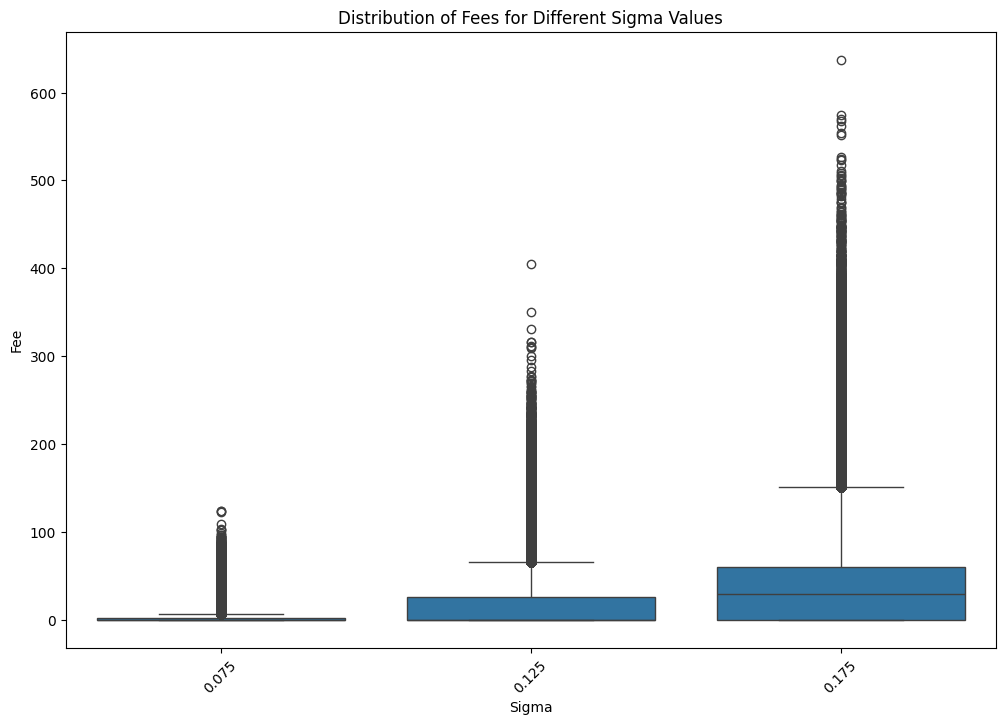

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the boxplot
sns.boxplot(x='sigma', y='total_fee', data=results)

# rotate the x-axis labels
plt.xticks(rotation=45)
# Set the labels and title
plt.xlabel('Sigma')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Sigma Values')

# Show the plot
plt.show()



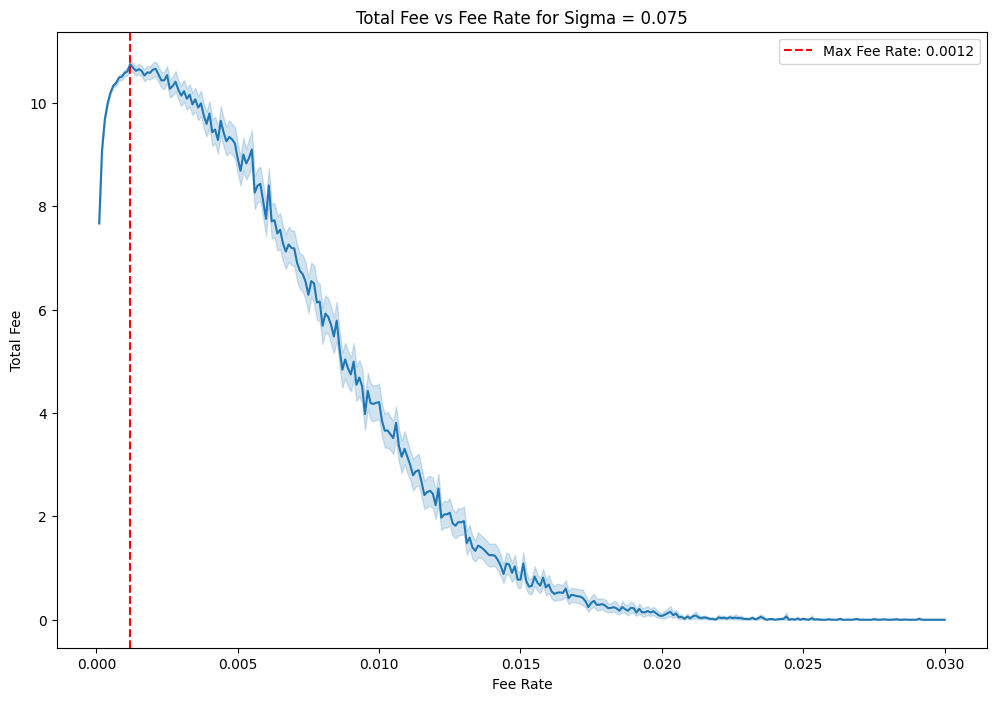

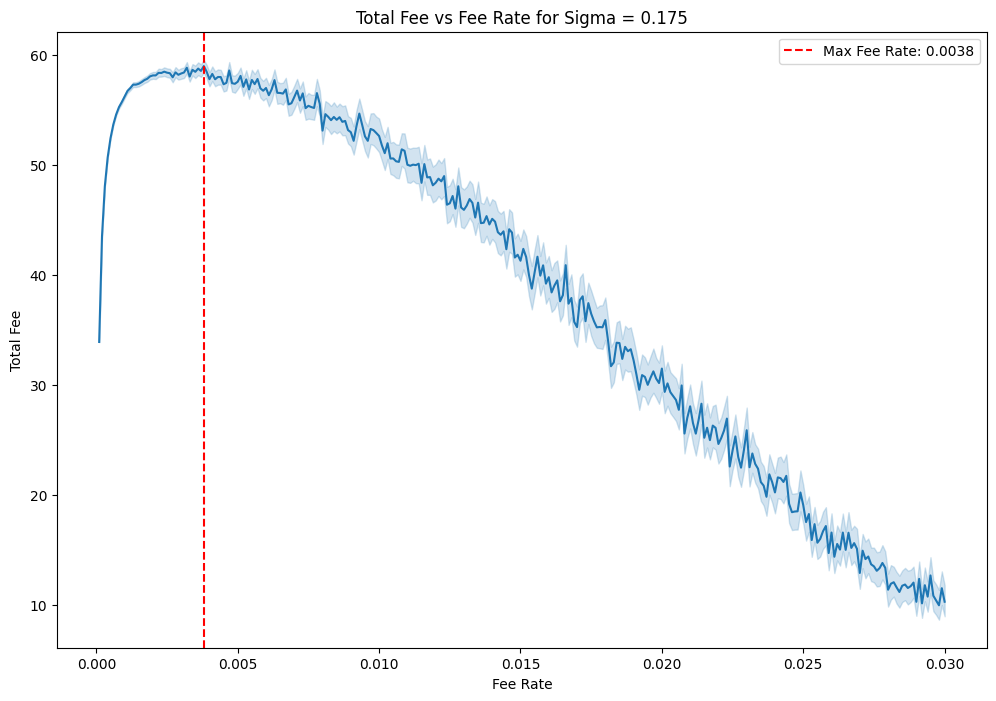

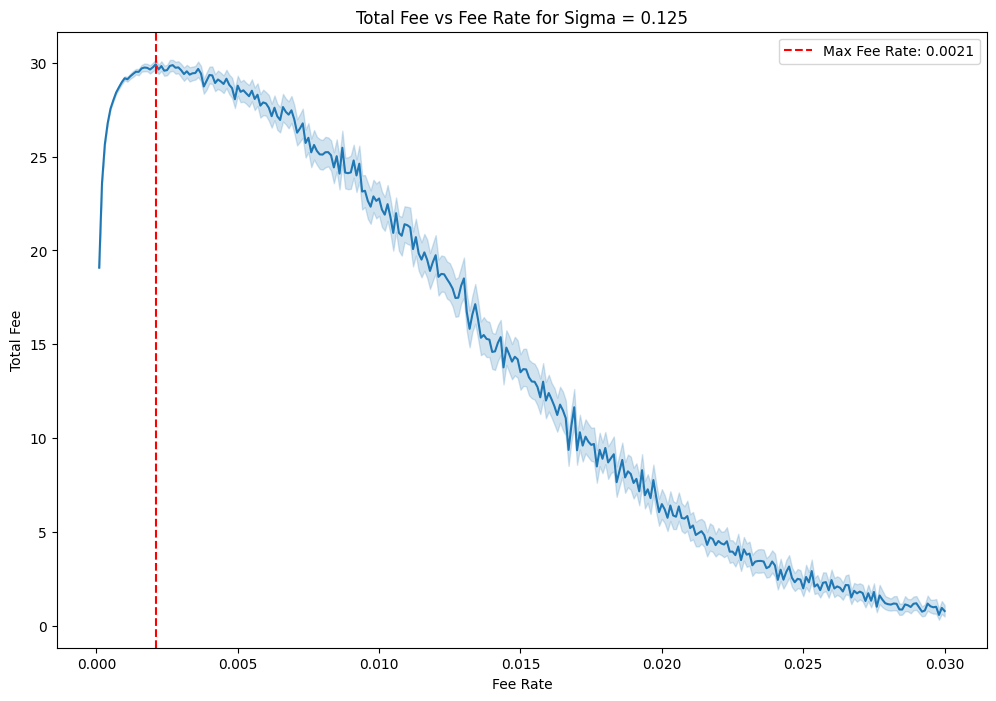

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sigma_values = results.sigma.unique()
for sigma in sigma_values:
    df = results[results.sigma == sigma]
    # Group by fee_rate and calculate the mean of total_fee
    grouped_df = df.groupby('fee_rate')['total_fee'].mean().reset_index()
    max_fee_rate = grouped_df.loc[grouped_df.total_fee.idxmax(), 'fee_rate']
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='fee_rate', y='total_fee', data=df)
    plt.xlabel('Fee Rate')
    plt.ylabel('Total Fee')
    plt.title(f'Total Fee vs Fee Rate for Sigma = {sigma}')
    # Draw a vertical line at the fee rate where the total fee is maximized
    plt.axvline(x=max_fee_rate, color='r', linestyle='--', label=f'Max Fee Rate: {max_fee_rate:.4f}')
    plt.legend()
    
    plt.show()
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def kneedle(x, y, S=1.0):
    """
    Implementation of the Kneedle algorithm to find the elbow point.
    :param x: Array of x values (e.g., fee rates).
    :param y: Array of y values (e.g., mean fees).
    :param S: Sensitivity parameter to adjust the sensitivity of the algorithm.
    :return: The x value (fee rate) at the elbow point.
    """
    # Normalize x and y values
    x_norm = (x - x.min()) / (x.max() - x.min())
    y_norm = (y - y.min()) / (y.max() - y.min())
    
    # Calculate the difference between the normalized y and the diagonal line
    diff = y_norm - x_norm
    
    # Find the point with the maximum curvature (elbow point)
    elbow_idx = np.argmax(diff)
    elbow_x = x[elbow_idx]
    
    return elbow_x

# Unique sigma values
unique_sigma = results['sigma'].unique()

# Set chunk size for plots (16 per chunk)
chunk_size = 16

# Split unique sigma values into chunks of the specified size
chunks = [unique_sigma[i:i + chunk_size] for i in range(0, len(unique_sigma), chunk_size)]

# Iterate through each chunk to create separate figures
for chunk_idx, chunk in enumerate(chunks):
    # Define the number of rows and columns for the subplots grid
    num_cols = 4
    num_rows = 4

    # Create subplots for this chunk
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    axes = axes.flatten()  # Flatten the axes for easy iteration

    # Loop through each sigma value in the current chunk and create a subplot
    for i, sigma in enumerate(chunk):
        df = results[results['sigma'] == sigma].copy()  # Filter for the current sigma
        
        # Group by fee_rate and calculate mean fee
        grouped = df.groupby('fee_rate')['fee'].mean().reset_index()
        
        # Extract fee rates and mean fees
        fee_rates = grouped['fee_rate'].values
        mean_fees = grouped['fee'].values
        
        # Apply the Kneedle algorithm to find the elbow point
        optimal_fee_rate = kneedle(fee_rates, mean_fees)
        
        # Plot the mean fee vs fee_rate
        sns.lineplot(x='fee_rate', y='fee', data=df, ax=axes[i])
        
        # Add a dashed line to indicate the elbow point
        axes[i].axvline(x=optimal_fee_rate, color='purple', linestyle='--')
        
        # Set labels and title
        axes[i].set_xlabel('fee_rate')
        axes[i].set_ylabel('fee')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_title(f'sigma={sigma} | optimal_fee_rate:{optimal_fee_rate:.4f}')
        
        # Get the current tick locations and add the optimal fee rate if it's not already present
        xticks = list(axes[i].get_xticks())
        if optimal_fee_rate not in xticks:
            xticks.append(optimal_fee_rate)  # Add the optimal fee rate to the tick locations
            xticks = sorted(xticks)  # Sort the ticks
        
        axes[i].set_xticks(xticks)  # Update the ticks on the x-axis
        
        # set x axis lim from 0 to 0.02
        axes[i].set_xlim(left=0)
        axes[i].set_xlim(right=0.02)
        
        # Highlight the x-tick that corresponds to the optimal fee rate
        xtick_labels = axes[i].get_xticklabels()
        for label in xtick_labels:
            try:
                tick_value = float(label.get_text())
                if abs(tick_value - optimal_fee_rate) < 1e-5:  # Checking if the tick corresponds to the optimal fee rate
                    label.set_color('red')
                    label.set_fontweight('bold')
            except ValueError:
                continue  # Skip labels that cannot be converted to float

        axes[i].set_xticklabels(xtick_labels)

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()


### Linear Regression : Max Mean fee rate VS. Sigma

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

# List to store sigma and corresponding fee_rate with highest mean fee
sigma_values = []
max_fee_rates = []
max_fee_results = {
    'sigma': [],
    'fee_rate': []
}

# Loop through each sigma
for sigma in unique_sigma:
    df = results[results['sigma'] == sigma].copy()  # Filter the dataframe for current sigma
    
    # Calculate the fee_rate with the highest mean fee for this sigma
    max_fee_rate = df.groupby('fee_rate')['fee'].mean().idxmax()
    elbow_fee_rate = kneedle(df['fee_rate'].values, df['fee'].values)
    
    # Store the sigma and the corresponding max fee_rate
    max_fee_results['sigma'].append(sigma)
    max_fee_results['fee_rate'].append(elbow_fee_rate)
    
    # sort the results by sigma
max_fee_results = pd.DataFrame(max_fee_results).sort_values('sigma')
    
print(max_fee_results)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def kneedle(x, y, S=1.0):
    """
    Implementation of the Kneedle algorithm to find the elbow point.
    :param x: Array of x values (e.g., fee rates).
    :param y: Array of y values (e.g., mean fees).
    :param S: Sensitivity parameter to adjust the sensitivity of the algorithm.
    :return: The x value (fee rate) at the elbow point.
    """
    # Normalize x and y values
    x_norm = (x - x.min()) / (x.max() - x.min())
    y_norm = (y - y.min()) / (y.max() - y.min())
    
    # Calculate the difference between the normalized y and the diagonal line
    diff = y_norm - x_norm
    
    # Find the point with the maximum curvature (elbow point)
    elbow_idx = np.argmax(diff)
    elbow_x = x[elbow_idx]
    
    return elbow_x

# sort the results by sigma and fee_rate
results = results.sort_values(['sigma', 'fee_rate'])

# Unique sigma values
unique_sigma = results['sigma'].unique()

# Set chunk size for plots (16 per chunk)
chunk_size = 16

# Split unique sigma values into chunks of the specified size
chunks = [unique_sigma[i:i + chunk_size] for i in range(0, len(unique_sigma), chunk_size)]

# Iterate through each chunk to create separate figures
for chunk_idx, chunk in enumerate(chunks):
    # Define the number of rows and columns for the subplots grid
    num_cols = 4
    num_rows = 4

    # Create subplots for this chunk
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    axes = axes.flatten()  # Flatten the axes for easy iteration

    # Loop through each sigma value in the current chunk and create a subplot
    for i, sigma in enumerate(chunk):
        df = results[results['sigma'] == sigma].copy()  # Filter for the current sigma
        
        # Group by fee_rate and calculate mean fee
        grouped = df.groupby('fee_rate')['fee'].mean().reset_index()
        
        # Extract fee rates and mean fees
        fee_rates = grouped['fee_rate'].values
        mean_fees = grouped['fee'].values
        
        # Apply the Kneedle algorithm to find the elbow point
        optimal_fee_rate = kneedle(fee_rates, mean_fees)
        
        # Plot the mean fee vs fee_rate
        sns.lineplot(x='fee_rate', y='fee', data=df, ax=axes[i])
        
        # Add a dashed line to indicate the elbow point
        axes[i].axvline(x=optimal_fee_rate, color='purple', linestyle='--')
        
        # Set labels and title
        axes[i].set_xlabel('fee_rate')
        axes[i].set_ylabel('fee')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_title(f'sigma={sigma} | optimal_fee_rate:{optimal_fee_rate:.4f}')
        
        # Get the current tick locations and add the optimal fee rate if it's not already present
        xticks = list(axes[i].get_xticks())
        if optimal_fee_rate not in xticks:
            xticks.append(optimal_fee_rate)  # Add the optimal fee rate to the tick locations
            xticks = sorted(xticks)  # Sort the ticks
        
        axes[i].set_xticks(xticks)  # Update the ticks on the x-axis
        
        # set x axis lim from 0 to 0.02
        axes[i].set_xlim(left=0)
        axes[i].set_xlim(right=0.02)
        
        # Highlight the x-tick that corresponds to the optimal fee rate
        xtick_labels = axes[i].get_xticklabels()
        for label in xtick_labels:
            try:
                tick_value = float(label.get_text())
                if abs(tick_value - optimal_fee_rate) < 1e-5:  # Checking if the tick corresponds to the optimal fee rate
                    label.set_color('red')
                    label.set_fontweight('bold')
            except ValueError:
                continue  # Skip labels that cannot be converted to float

        axes[i].set_xticklabels(xtick_labels)

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# plot the fee_rate with the highest mean fee for each sigma
plt.figure(figsize=(12, 8))
sns.lineplot(x='sigma', y='fee_rate', data=max_fee_results, marker='o')
plt.xlabel('Sigma')
plt.ylabel('Fee Rate with Highest Mean Fee')
plt.title('Fee Rate with Highest Mean Fee for Different Sigma Values')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

# List to store sigma and corresponding fee_rate with highest mean fee
sigma_values = []
max_fee_rates = []

# Loop through each sigma
for sigma in unique_sigma:
    df = results[results['sigma'] == sigma].copy()  # Filter the dataframe for current sigma
    
    # Calculate the fee_rate with the highest mean fee for this sigma
    max_fee_rate = df.groupby('fee_rate')['fee'].mean().idxmax()
    
    # Store the sigma and the corresponding max fee_rate
    sigma_values.append(sigma)
    max_fee_rates.append(max_fee_rate)

# Prepare the data (assuming you already have sigma_values and max_fee_rates lists)
plot_data = pd.DataFrame({'sigma': sigma_values, 'max_fee_rate': max_fee_rates})

# Features and target
X = plot_data[['sigma']]  # Independent variable
y = plot_data['max_fee_rate']  # Dependent variable

# Define a piecewise function
def piecewise_linear(x, x0, y0, k1, k2):
    return np.where(x < x0, k1 * x + y0, k2 * (x - x0) + (k1 * x0 + y0))

# Fit the piecewise model
x_data = plot_data['sigma'].values
y_data = plot_data['elbow_fee_rate'].values

# Initial guess for parameters: (x0, y0, k1, k2)
initial_guess = [0.1, 0.001, 0.01, 0]

# Fit the model using curve_fit
params, _ = curve_fit(piecewise_linear, x_data, y_data, p0=initial_guess)

# Extract the parameters
x0, y0, k1, k2 = params

# Generate predictions
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = piecewise_linear(x_fit, *params)

# Plot the data and the fitted model
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sigma', y='elbow_fee_rate', data=plot_data, color='blue', label='Elbow Fee Rate Data')
plt.plot(x_fit, y_fit, color='red', label='Piecewise Linear Fit')
plt.xlabel('Sigma')
plt.ylabel('Elbow Fee Rate')
plt.title('Piecewise Linear Regression: Sigma vs. Elbow Fee Rate')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters:")
print(f"x0 (transition point): {x0}")
print(f"y0 (initial value): {y0}")
print(f"k1 (slope of the first segment): {k1}")
print(f"k2 (slope of the second segment): {k2}")


In [ ]:
# download SP500 daily data in from 2020-01-01 to 2024-10-01 from yahoo finance
import yfinance as yf
import pandas as pd

# Download SP500 data from Yahoo Finance
spy = yf.download('SPY', start='2020-01-01', end='2024-10-01')


In [28]:
# calculate the daily returns and volatility
spy['daily_return'] = spy['Adj Close'].pct_change()
spy['volatility'] = spy['daily_return'].rolling(window=20).std()
spy['annualized_volatility'] = spy['volatility'] * (252 ** 0.5)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns   
# draw a histogram of the annualized volatility
plt.figure(figsize=(12, 8))
sns.histplot(spy['annualized_volatility'].dropna(), kde=True)
plt.xticks(rotation=45)
# increase number of ticks on x-axis
plt.locator_params(axis='x', nbins=20)
plt.title('Distribution of Annualized Volatility for SPY (2020-2024)')

In [ ]:
# calculate the anualized return
spy['annualized_return'] = (1 + spy['daily_return']).cumprod() ** (252 / len(spy)) - 1

# draw a histogram of the annualized return
plt.figure(figsize=(12, 8))
sns.histplot(spy['annualized_return'].dropna(), kde=True)
plt.xticks(rotation=45)
# increase number of ticks on x-axis
plt.locator_params(axis='x', nbins=20)
plt.title('Distribution of Annualized Return for SPY (2020-2024)')
# add a vertical line on the mean and write it in the legend
plt.axvline(spy['annualized_return'].mean(), color='red', linestyle='--', label=f'Mean: {spy["annualized_return"].mean():.4f}')
plt.legend()    

plt.show()



In [ ]:
from arch import arch_model
import yfinance as yf
import numpy as np
import pandas as pd

# Download SPY data
spy = yf.download('SPY', start='2020-01-01', end='2024-10-01')

# Calculate log returns
spy['Log_Returns'] = np.log(spy['Adj Close'] / spy['Adj Close'].shift(1))
spy = spy.dropna()

# Iterate over different combinations of p and q
best_aic = np.inf  # Initialize with a high value
best_order = None
best_model = None

for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = arch_model(spy['Log_Returns'], vol='Garch', p=p, q=q)
            model_fit = model.fit(disp='off')
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
                best_model = model_fit
        except Exception as e:
            print(f"Model GARCH({p},{q}) failed with error: {e}")

print(f"Best model order: GARCH{best_order} with AIC: {best_aic}")
print(best_model.summary())


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Step 1: Download SPY daily data using yfinance
spy = yf.download('SPY', start='2020-01-01', end='2024-10-01')

# Step 2: Calculate the daily log returns
spy['Log_Returns'] = np.log(spy['Adj Close'] / spy['Adj Close'].shift(1))

# Step 3: Drop any missing values (e.g., from the shift operation)
spy = spy.dropna()

# Step 4: Fit a GARCH(2,2) model to the log returns
model = arch_model(spy['Log_Returns'], vol='Garch', p=2, q=2)
garch_fit = model.fit(disp='off')

# Step 5: Print the summary of the model fit
print(garch_fit.summary())

# Step 6: Plot the conditional volatility (standard deviation) over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(garch_fit.conditional_volatility, label='Conditional Volatility (GARCH 2,2)')
ax.set_title('Estimated Daily Volatility of SPY (GARCH 2,2 Model)')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
plt.legend()
plt.show()

# Optional: Save the fitted parameters for later use
params = garch_fit.params
alpha0 = params['omega']
alpha1 = params['alpha[1]']
alpha2 = params['alpha[2]']
beta1 = params['beta[1]']
beta2 = params['beta[2]']

print(f"\nTrained GARCH(2,2) Parameters:")
print(f"alpha0 (omega): {alpha0}")
print(f"alpha1 (alpha[1]): {alpha1}")
print(f"alpha2 (alpha[2]): {alpha2}")
print(f"beta1 (beta[1]): {beta1}")
print(f"beta2 (beta[2]): {beta2}")


In [ ]:
print(results.head())

In [ ]:
# draw boxplot of fee for different fee rates
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

file_path = '/home/shiftpub/Dynamic_AMM/results/dummy_results/sp500_simulation_result_second_with_random_volatility.csv'
results = pd.read_csv(file_path)
unique_fee_rate = results['fee_rate'].unique()
print(results.columns)
# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the boxplot
sns.boxplot(x='fee_rate', y='fee', data=results)

# rotate the x-axis labels
plt.xticks(rotation=45)
# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates')

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/home/shiftpub/Dynamic_AMM/results/dummy_results/sp500_simulation_result_dynamic_fee_rate.csv'
results = pd.read_csv(file_path)

# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the boxplot
# sns.boxplot(x='fee_rate', y='fee', data=results)
plt.hist(results['fee'], bins=20, color='blue', alpha=0.7)
# rotate the x-axis labels
plt.xticks(rotation=45)
# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# File paths
dynamic_result = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/dynamic_simulation_results_20241009_163710.csv')
static_result = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/static_simulation_results_20241009_162927.csv')

# Add a new column to identify dynamic fees
dynamic_result['fee_rate'] = 'dynamic'

# extract statis result for fee_rate <=0.35
# static_result = static_result[static_result['fee_rate'] <= 0.0035]
# Combine the two DataFrames
combined_results = pd.concat([static_result, dynamic_result], ignore_index=True)
# Set up the figure
plt.figure(figsize=(14, 8))

# Draw the boxplot with dynamic fees included
sns.boxplot(x='fee_rate', y='fee', data=combined_results)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates Including Dynamic Fees')

# Show the plot
plt.show()


In [ ]:
# Set up the figure
plt.figure(figsize=(14, 8))

# Draw the boxplot with dynamic fees included
sns.boxplot(x='fee_rate', y='pnl', data=combined_results)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates Including Dynamic Fees')

# Show the plot
plt.show()


In [ ]:
print(results.fee_rate.unique())

In [ ]:
# plot fee vs fee_rate
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the scatter plot
sns.boxplot(x='fee_rate', y='fee', data=results)

# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Fee vs Fee Rate')

# Show the plot
plt.show()

In [ ]:
df = results[results['sigma'] == 0.5].copy()  # Filter for the current sigma

def plot_fee(df):
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='fee_rate', y='fee', data=df)
    plt.xlabel('Fee Rate')
    plt.ylabel('Fee')
    plt.title('Fee vs Fee Rate')
    plt.show()
    
plot_fee(df)


# draw subplots for every sigma
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def kneedle(x, y, S=1.0):
    """
    Implementation of the Kneedle algorithm to find the elbow point.
    :param x: Array of x values (e.g., fee rates).
    :param y: Array of y values (e.g., mean fees).
    :param S: Sensitivity parameter to adjust the sensitivity of the algorithm.
    :return: The x value (fee rate) at the elbow point.
    """
    # Normalize x and y values
    x_norm = (x - x.min()) / (x.max() - x.min())
    y_norm = (y - y.min()) / (y.max() - y.min())
    
    # Calculate the difference between the normalized y and the diagonal line
    diff = y_norm - x_norm
    
    # Find the point with the maximum curvature (elbow point)
    elbow_idx = np.argmax(diff)
    elbow_x = x[elbow_idx]
    
    return elbow_x

# sort the results by sigma and fee_rate
results = results.sort_values(['sigma', 'fee_rate'])

# Unique sigma values
unique_sigma = results['sigma'].unique()

# Set chunk size for plots (16 per chunk)
chunk_size = 16

# Split unique sigma values into chunks of the specified size
chunks = [unique_sigma[i:i + chunk_size] for i in range(0, len(unique_sigma), chunk_size)]

# Iterate through each chunk to create separate figures

for chunk_idx, chunk in enumerate(chunks):
    # Define the number of rows and columns for the subplots grid
    num_cols = 4
    num_rows = 4

    # Create subplots for this chunk
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    axes = axes.flatten()  # Flatten the axes for easy iteration

    # Loop through each sigma value in the current chunk and create a subplot
    for i, sigma in enumerate(chunk):
        df = results[results['sigma'] == sigma].copy()  # Filter for the current sigma
        
        # Group by fee_rate and calculate mean fee
        grouped = df.groupby('fee_rate')['fee'].mean().reset_index()
        
        # Extract fee rates and mean fees
        fee_rates = grouped['fee_rate'].values
        mean_fees = grouped['fee'].values
        
        # Apply the Kneedle algorithm to find the elbow point
        optimal_fee_rate = kneedle(fee_rates, mean_fees)
        
        # Plot the mean fee vs fee_rate
        sns.lineplot(x='fee_rate', y='fee', data=df, ax=axes[i])
        
        # Add a dashed line to indicate the elbow point
        axes[i].axvline(x=optimal_fee_rate, color='purple', linestyle='--')
        
        # Set labels and title
        axes[i].set_xlabel('fee_rate')
        axes[i].set_ylabel('fee')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_title(f'sigma={sigma} | optimal_fee_rate:{optimal_fee_rate:.4f}')
        
        
    


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot subplots for each unique sigma value
def plot_fee_for_all_sigmas(df):
    unique_sigmas = df['sigma'].unique()  # Get unique sigma values
    num_sigmas = len(unique_sigmas)  # Number of unique sigmas
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_sigmas, 1, figsize=(12, 8 * num_sigmas), sharex=True)
    
    # If only one sigma is present, axes will not be iterable, so make it a list
    if num_sigmas == 1:
        axes = [axes]
    
    # Loop over unique sigmas and create a plot for each
    for i, sigma in enumerate(unique_sigmas):
        sigma_df = df[df['sigma'] == sigma]  # Filter for current sigma
        
        # Plotting on the specific subplot axis
        sns.lineplot(ax=axes[i], x='fee_rate', y='fee', data=sigma_df)
        axes[i].set_title(f'Fee vs Fee Rate for Sigma = {sigma}')
        axes[i].set_xlabel('Fee Rate')
        axes[i].set_ylabel('Fee')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Assuming df contains multiple sigma values, we call the function
plot_fee_for_all_sigmas(results)


In [ ]:
print(results.head())
print(results.columns)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator  # for detecting elbow point
import seaborn as sns
import pandas as pd

df = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined.csv')
# sort df by sigma and fee_rate
df = df.sort_values(['sigma', 'fee_rate'])

# Assuming your DataFrame is named df
def find_elbow_for_sigma(df):
    sigmas = df['sigma'].unique()
    
    # Create subplots for each sigma
    fig, axes = plt.subplots(len(sigmas), 1, figsize=(10, 5 * len(sigmas)))
    
    if len(sigmas) == 1:
        axes = [axes]  # Ensure axes is iterable
    
    for i, sigma in enumerate(sigmas):
        sigma_df = df[df['sigma'] == sigma]  # Filter data for current sigma
        
        # Sort by fee_rate to ensure correct plotting
        sigma_df = sigma_df.sort_values(by='fee_rate')
        
        fee_rates = sigma_df['fee_rate'].values
        fees = sigma_df['fee'].values
        
        # Ensure x and y are the same length
        if len(fee_rates) != len(fees):
            print(f"Error: fee_rates and fees lengths mismatch for sigma = {sigma}")
            continue
        
        # Detect the elbow point using KneeLocator
        kneedle = KneeLocator(fee_rates, fees, curve='convex', direction='increasing')
        elbow_point = kneedle.elbow  # Get the elbow point
        
        # Plot the fee vs fee_rate
        sns.lineplot(x=fee_rates, y=fees, ax=axes[i])
        
        # Check if elbow_point is detected
        if elbow_point is not None:
            elbow_fee = sigma_df[sigma_df['fee_rate'] == elbow_point]['fee'].values[0]
            axes[i].scatter(elbow_point, elbow_fee, color='red', label='Elbow Point')
        
        axes[i].set_title(f'Sigma = {sigma} (Elbow at {elbow_point:.4f})' if elbow_point else f'Sigma = {sigma}')
        axes[i].set_xlabel('Fee Rate')
        axes[i].set_ylabel('Fee')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Call the function to find elbow points and visualize
find_elbow_for_sigma(df)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator  # for detecting elbow point
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter  # For smoothing

df = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined.csv')
# sort df by sigma and fee_rate
df = df.sort_values(['sigma', 'fee_rate'])

# Assuming your DataFrame is named df
def find_elbow_for_sigma(df):
    sigmas = df['sigma'].unique()
    
    # Create subplots for each sigma
    fig, axes = plt.subplots(len(sigmas), 1, figsize=(10, 5 * len(sigmas)))
    
    if len(sigmas) == 1:
        axes = [axes]  # Ensure axes is iterable
    
    for i, sigma in enumerate(sigmas):
        sigma_df = df[df['sigma'] == sigma]  # Filter data for current sigma
        
        # Sort by fee_rate to ensure correct plotting
        sigma_df = sigma_df.sort_values(by='fee_rate')
        
        fee_rates = sigma_df['fee_rate'].values
        fees = sigma_df['fee'].values
        
        # Ensure x and y are the same length
        if len(fee_rates) != len(fees):
            print(f"Error: fee_rates and fees lengths mismatch for sigma = {sigma}")
            continue
        
        # Smooth the curve using Savitzky-Golay filter
        # window_length must be an odd number and no larger than the size of fees array
        smoothed_fees = savgol_filter(fees, window_length=11, polyorder=2)
        
        # Detect the elbow point using the smoothed data
        kneedle = KneeLocator(fee_rates, smoothed_fees, curve='convex', direction='increasing')
        elbow_point = kneedle.elbow  # Get the elbow point
        
        # Plot the smoothed fee vs fee_rate
        sns.lineplot(x=fee_rates, y=smoothed_fees, ax=axes[i], label='Smoothed Curve')
        
        # Plot the original fees for reference
        sns.scatterplot(x=fee_rates, y=fees, ax=axes[i], color='blue', label='Original Data')
        
        # Add a dashed line for the highest smoothed value
        max_fee = np.max(smoothed_fees)
        max_fee_rate = fee_rates[np.argmax(smoothed_fees)]
        axes[i].axhline(y=max_fee, color='green', linestyle='--', label='Max Smoothed Fee')
        
        # Check if elbow_point is detected and plot the elbow point
        if elbow_point is not None:
            elbow_fee = sigma_df[sigma_df['fee_rate'] == elbow_point]['fee'].values[0]
            axes[i].scatter(elbow_point, elbow_fee, color='red', label='Elbow Point')
        
        axes[i].set_title(f'Sigma = {sigma} (Elbow at {elbow_point:.4f})' if elbow_point else f'Sigma = {sigma}')
        axes[i].set_xlabel('Fee Rate')
        axes[i].set_ylabel('Fee')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Call the function to find elbow points and visualize
find_elbow_for_sigma(df)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter  # For smoothing

df = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined.csv')
# sort df by sigma and fee_rate
df = df.sort_values(['sigma', 'fee_rate'])

# Assuming your DataFrame is named df
def plot_smoothed_fee_rate(df):
    sigmas = df['sigma'].unique()
    
    # Create subplots for each sigma
    fig, axes = plt.subplots(len(sigmas), 1, figsize=(10, 5 * len(sigmas)))
    
    if len(sigmas) == 1:
        axes = [axes]  # Ensure axes is iterable
    
    for i, sigma in enumerate(sigmas):
        sigma_df = df[df['sigma'] == sigma]  # Filter data for current sigma
        
        # Sort by fee_rate to ensure correct plotting
        sigma_df = sigma_df.sort_values(by='fee_rate')
        
        fee_rates = sigma_df['fee_rate'].values
        fees = sigma_df['fee'].values
        
        # Smooth the curve using Savitzky-Golay filter
        smoothed_fees = savgol_filter(fees, window_length=11, polyorder=2)
        
        # Plot the smoothed fee vs fee_rate
        sns.lineplot(x=fee_rates, y=smoothed_fees, ax=axes[i], label='Smoothed Curve')
        
        axes[i].set_title(f'Sigma = {sigma}')
        axes[i].set_xlabel('Fee Rate')
        axes[i].set_ylabel('Fee')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Call the function to visualize smoothed line plots
plot_smoothed_fee_rate(df)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter  # For smoothing

df = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined.csv')
# sort df by sigma and fee_rate
df = df.sort_values(['sigma', 'fee_rate'])

# Assuming your DataFrame is named df
def plot_smoothed_fee_rate(df):
    sigmas = df['sigma'].unique()
    
    # Create subplots for each sigma
    fig, axes = plt.subplots(len(sigmas), 1, figsize=(10, 5 * len(sigmas)))
    
    if len(sigmas) == 1:
        axes = [axes]  # Ensure axes is iterable
    
    for i, sigma in enumerate(sigmas):
        sigma_df = df[df['sigma'] == sigma]  # Filter data for current sigma
        
        # Sort by fee_rate to ensure correct plotting
        sigma_df = sigma_df.sort_values(by='fee_rate')
        
        fee_rates = sigma_df['fee_rate'].values
        fees = sigma_df['fee'].values
        
        # Smooth the curve using Savitzky-Golay filter
        smoothed_fees = savgol_filter(fees, window_length=11, polyorder=2)
        
        # Plot the smoothed fee vs fee_rate on the corresponding subplot
        sns.lineplot(x=fee_rates, y=smoothed_fees, ax=axes[i], label='Smoothed Curve')
        
        # Set title and labels for the subplot
        axes[i].set_title(f'Sigma = {sigma}')
        axes[i].set_xlabel('Fee Rate')
        axes[i].set_ylabel('Fee')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Call the function to visualize smoothed line plots
plot_smoothed_fee_rate(df)


In [39]:
import numpy as np
import pandas as pd
import glob

# import all csv files and concatenate them into one dataframe
path = '/home/shiftpub/Dynamic_AMM/results/dummy_results/'
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

df.to_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined2.csv', index=False)

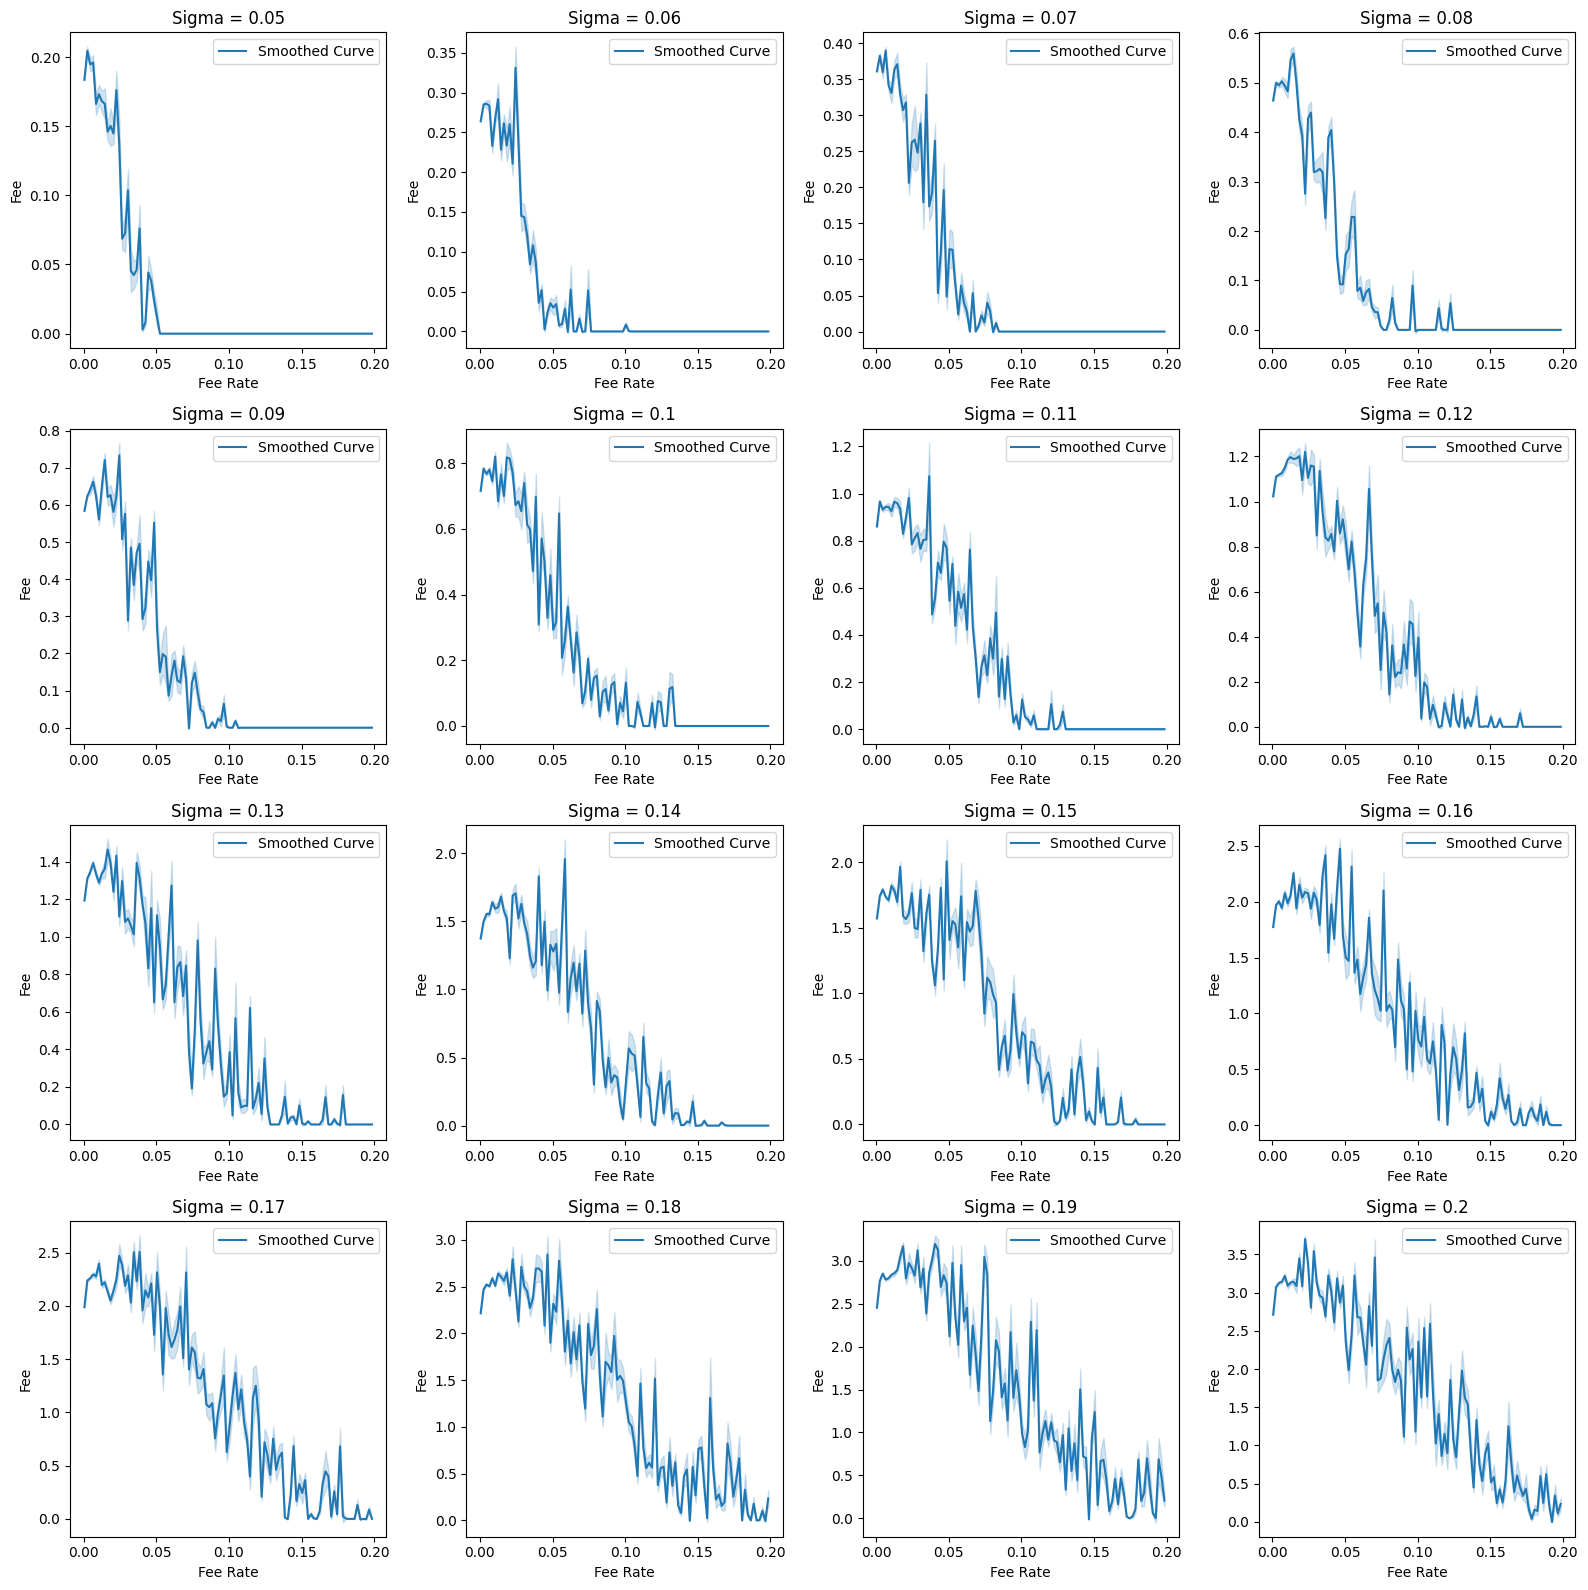

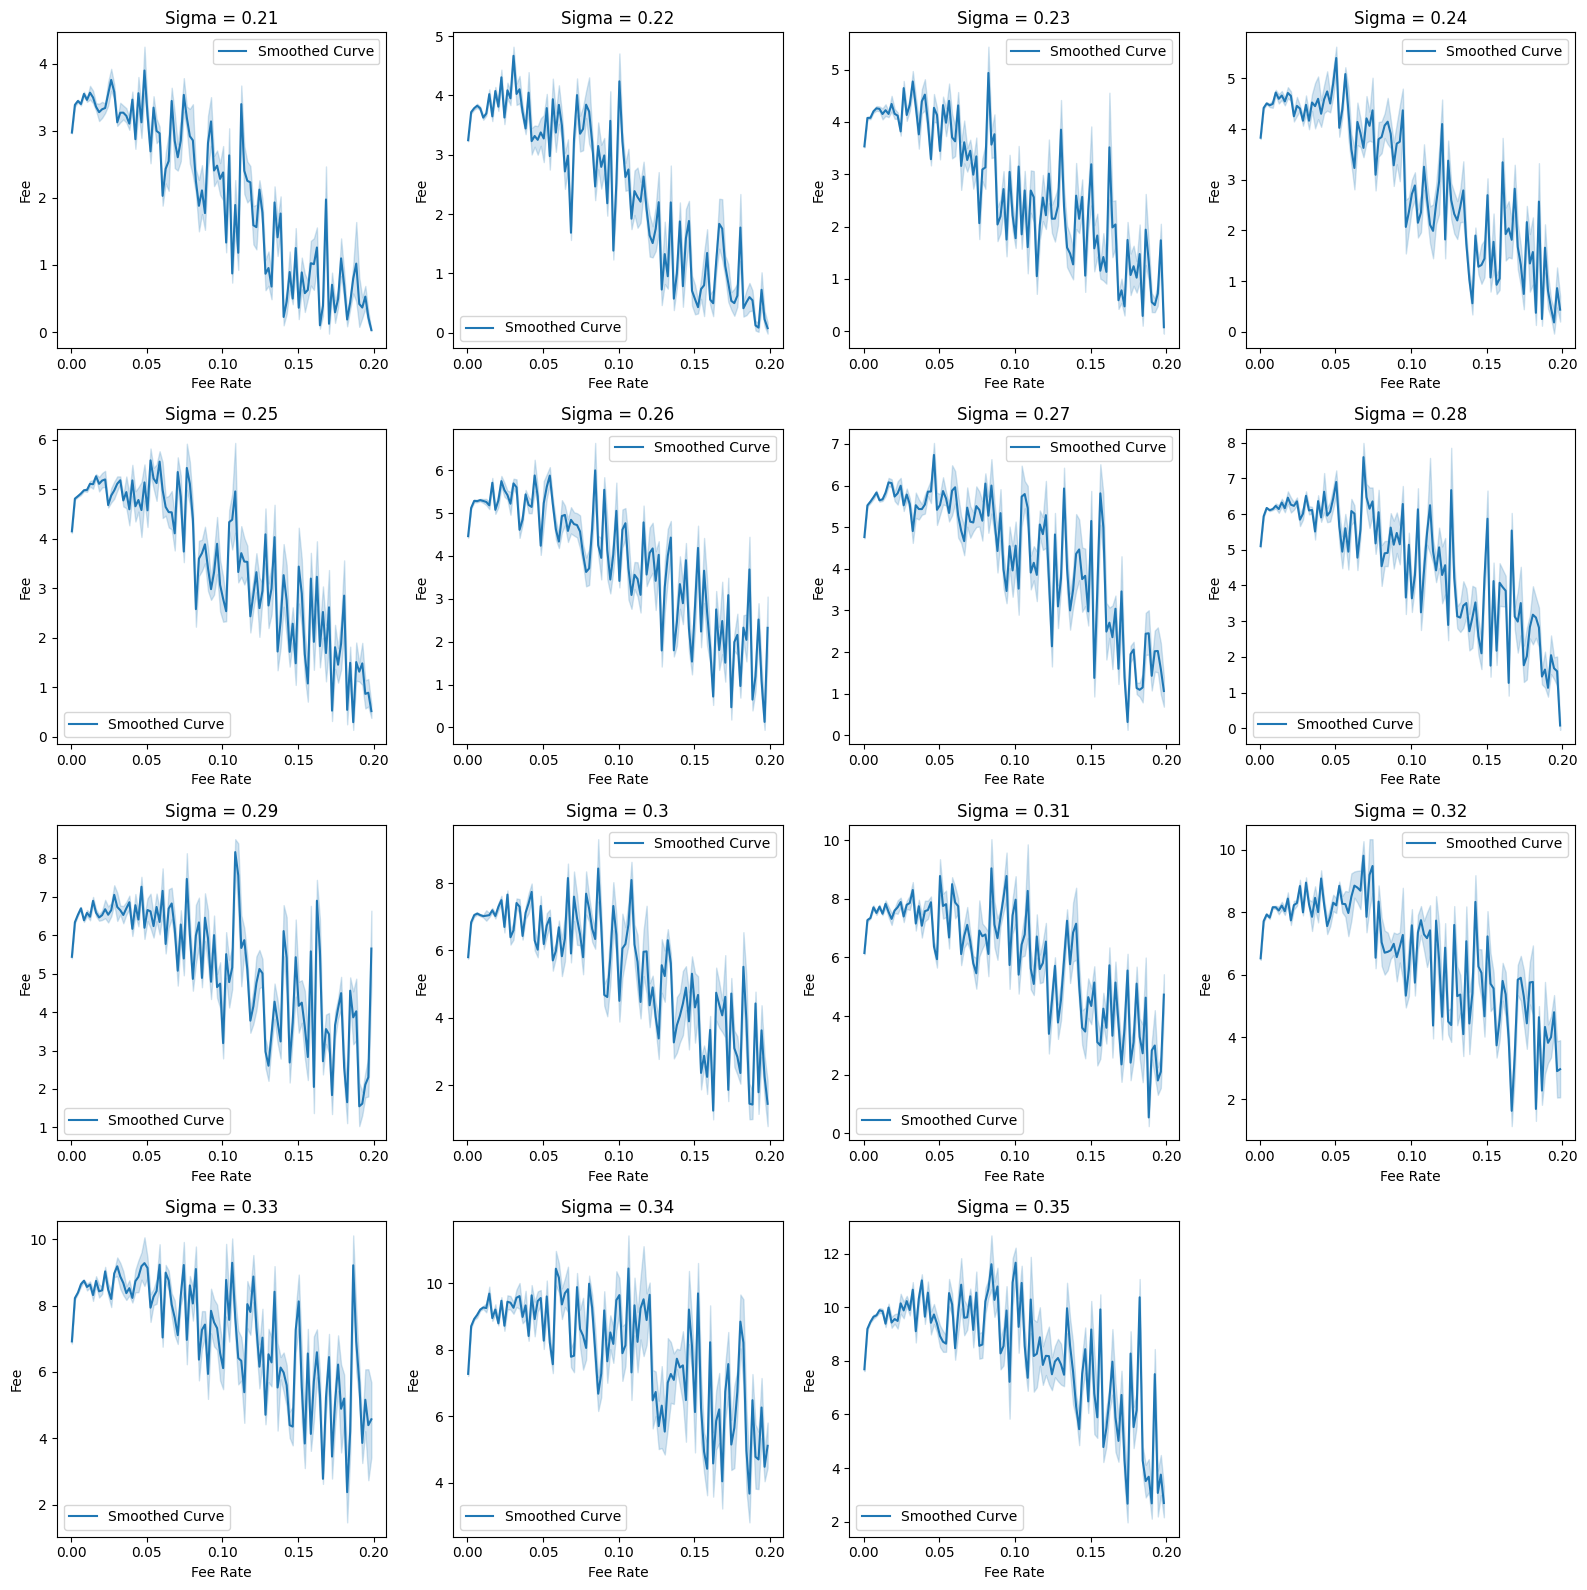

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter  # For smoothing

df = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined2.csv')
# sort df by sigma and fee_rate
df = df.sort_values(['sigma', 'fee_rate'])

# Assuming your DataFrame is named df
def plot_smoothed_fee_rate(df):
    sigmas = df['sigma'].unique()
    total_sigmas = len(sigmas)
    
    # Determine the number of figures needed (each figure will have 16 subplots)
    num_figures = (total_sigmas // 16) + (1 if total_sigmas % 16 != 0 else 0)
    
    for fig_num in range(num_figures):
        # Create a 4x4 grid of subplots
        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        axes = axes.flatten()  # Flatten axes to make it iterable

        # Get the sigma values for this figure (up to 16 per figure)
        start_idx = fig_num * 16
        end_idx = min(start_idx + 16, total_sigmas)
        current_sigmas = sigmas[start_idx:end_idx]

        for i, sigma in enumerate(current_sigmas):
            sigma_df = df[df['sigma'] == sigma]  # Filter data for current sigma
            
            # Sort by fee_rate to ensure correct plotting
            sigma_df = sigma_df.sort_values(by='fee_rate')
            
            fee_rates = sigma_df['fee_rate'].values
            fees = sigma_df['fee'].values
            
            # Smooth the curve using Savitzky-Golay filter
            smoothed_fees = savgol_filter(fees, window_length=20, polyorder=2)
            
            # Plot the smoothed fee vs fee_rate on the corresponding subplot
            sns.lineplot(x=fee_rates, y=smoothed_fees, ax=axes[i], label='Smoothed Curve')
            
            # Set title and labels for the subplot
            axes[i].set_title(f'Sigma = {sigma}')
            axes[i].set_xlabel('Fee Rate')
            axes[i].set_ylabel('Fee')

        # Remove any unused subplots (if less than 16 sigma in the last figure)
        for j in range(len(current_sigmas), 16):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.savefig(f'smoothed_fee_rate_figure_{fig_num}.png')
        plt.show()

# Call the function to visualize smoothed line plots
plot_smoothed_fee_rate(df)


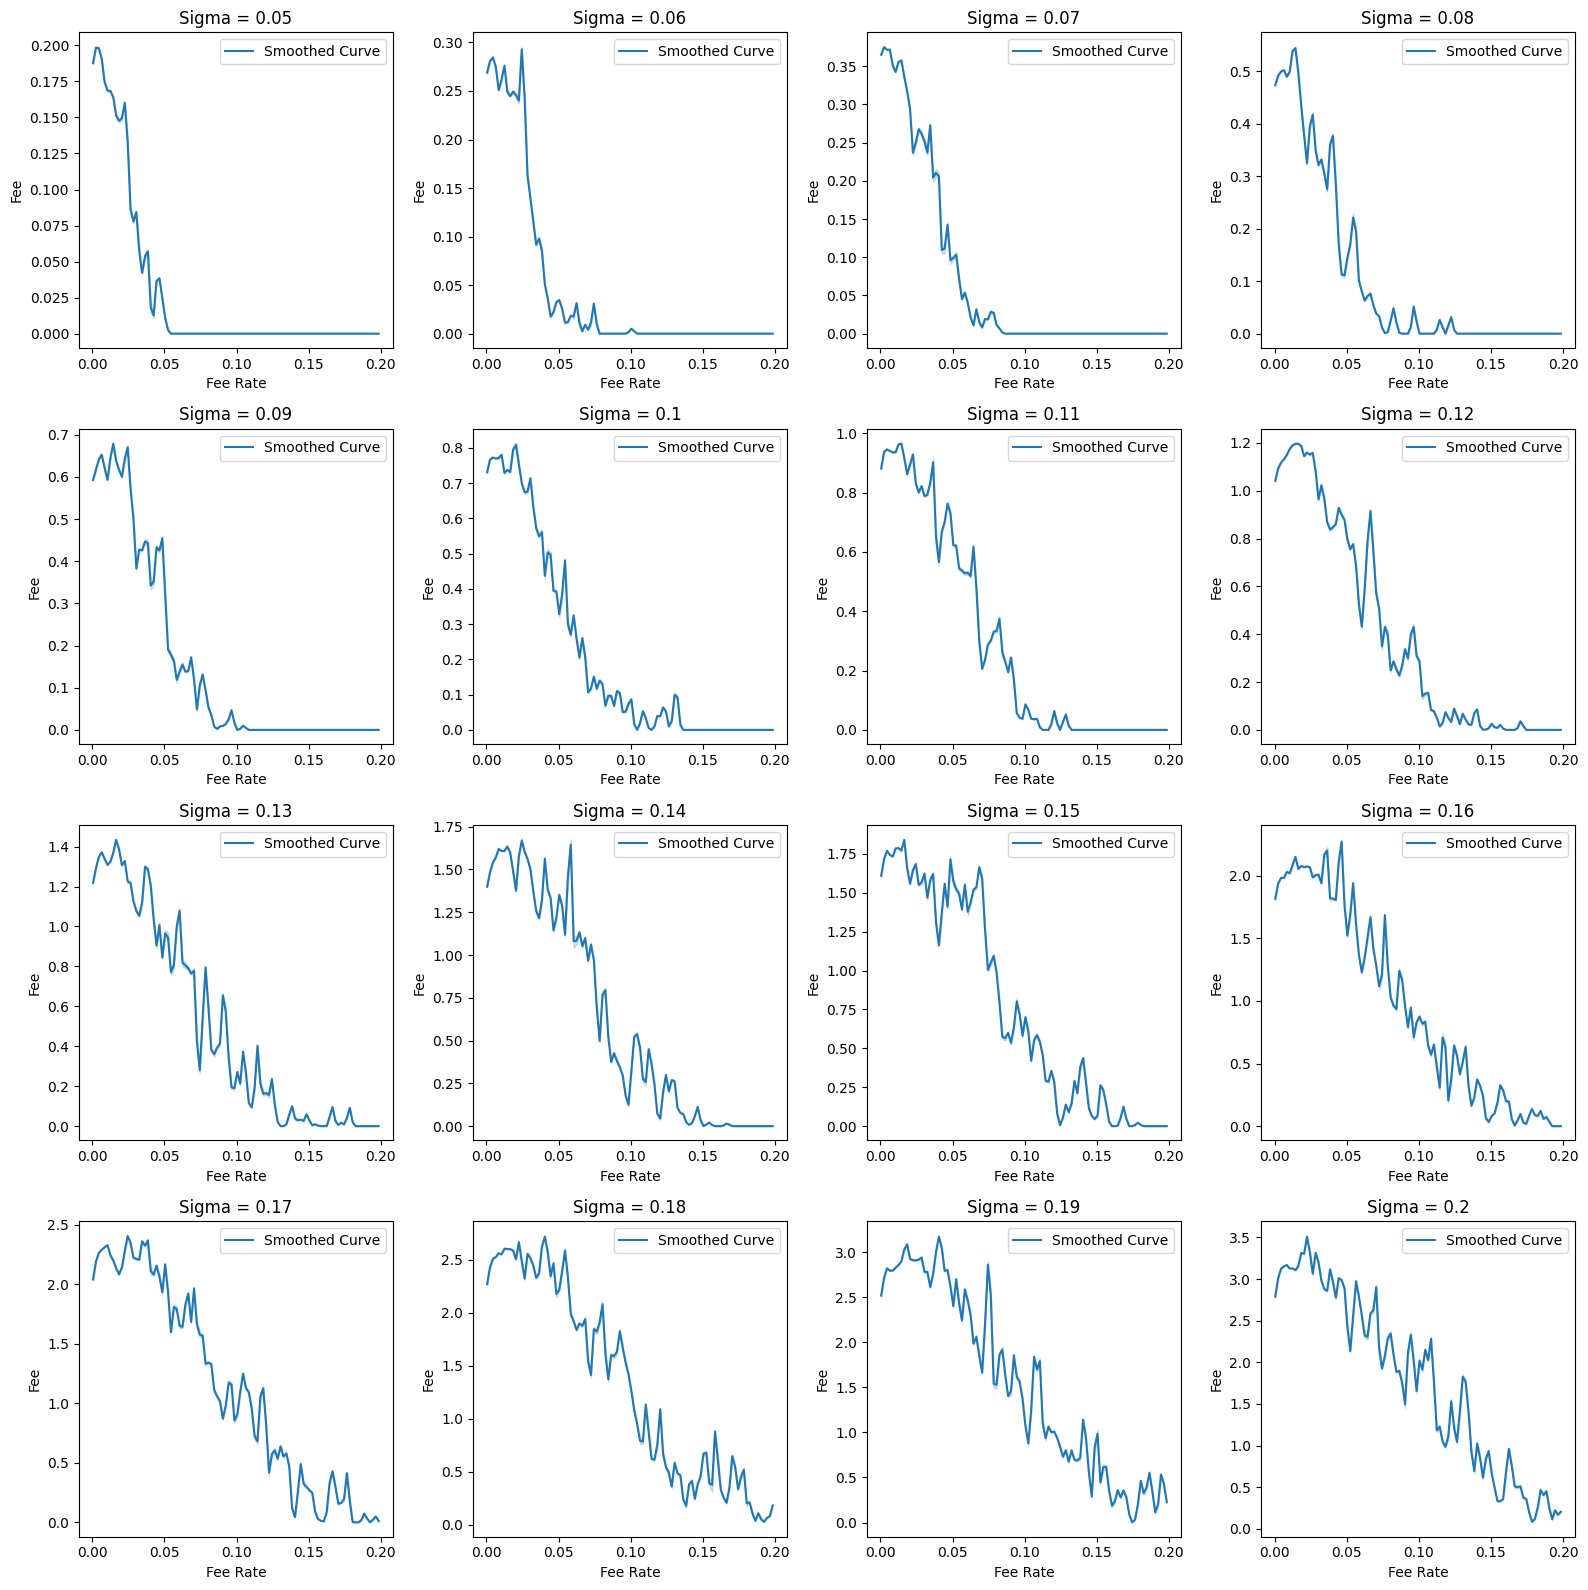

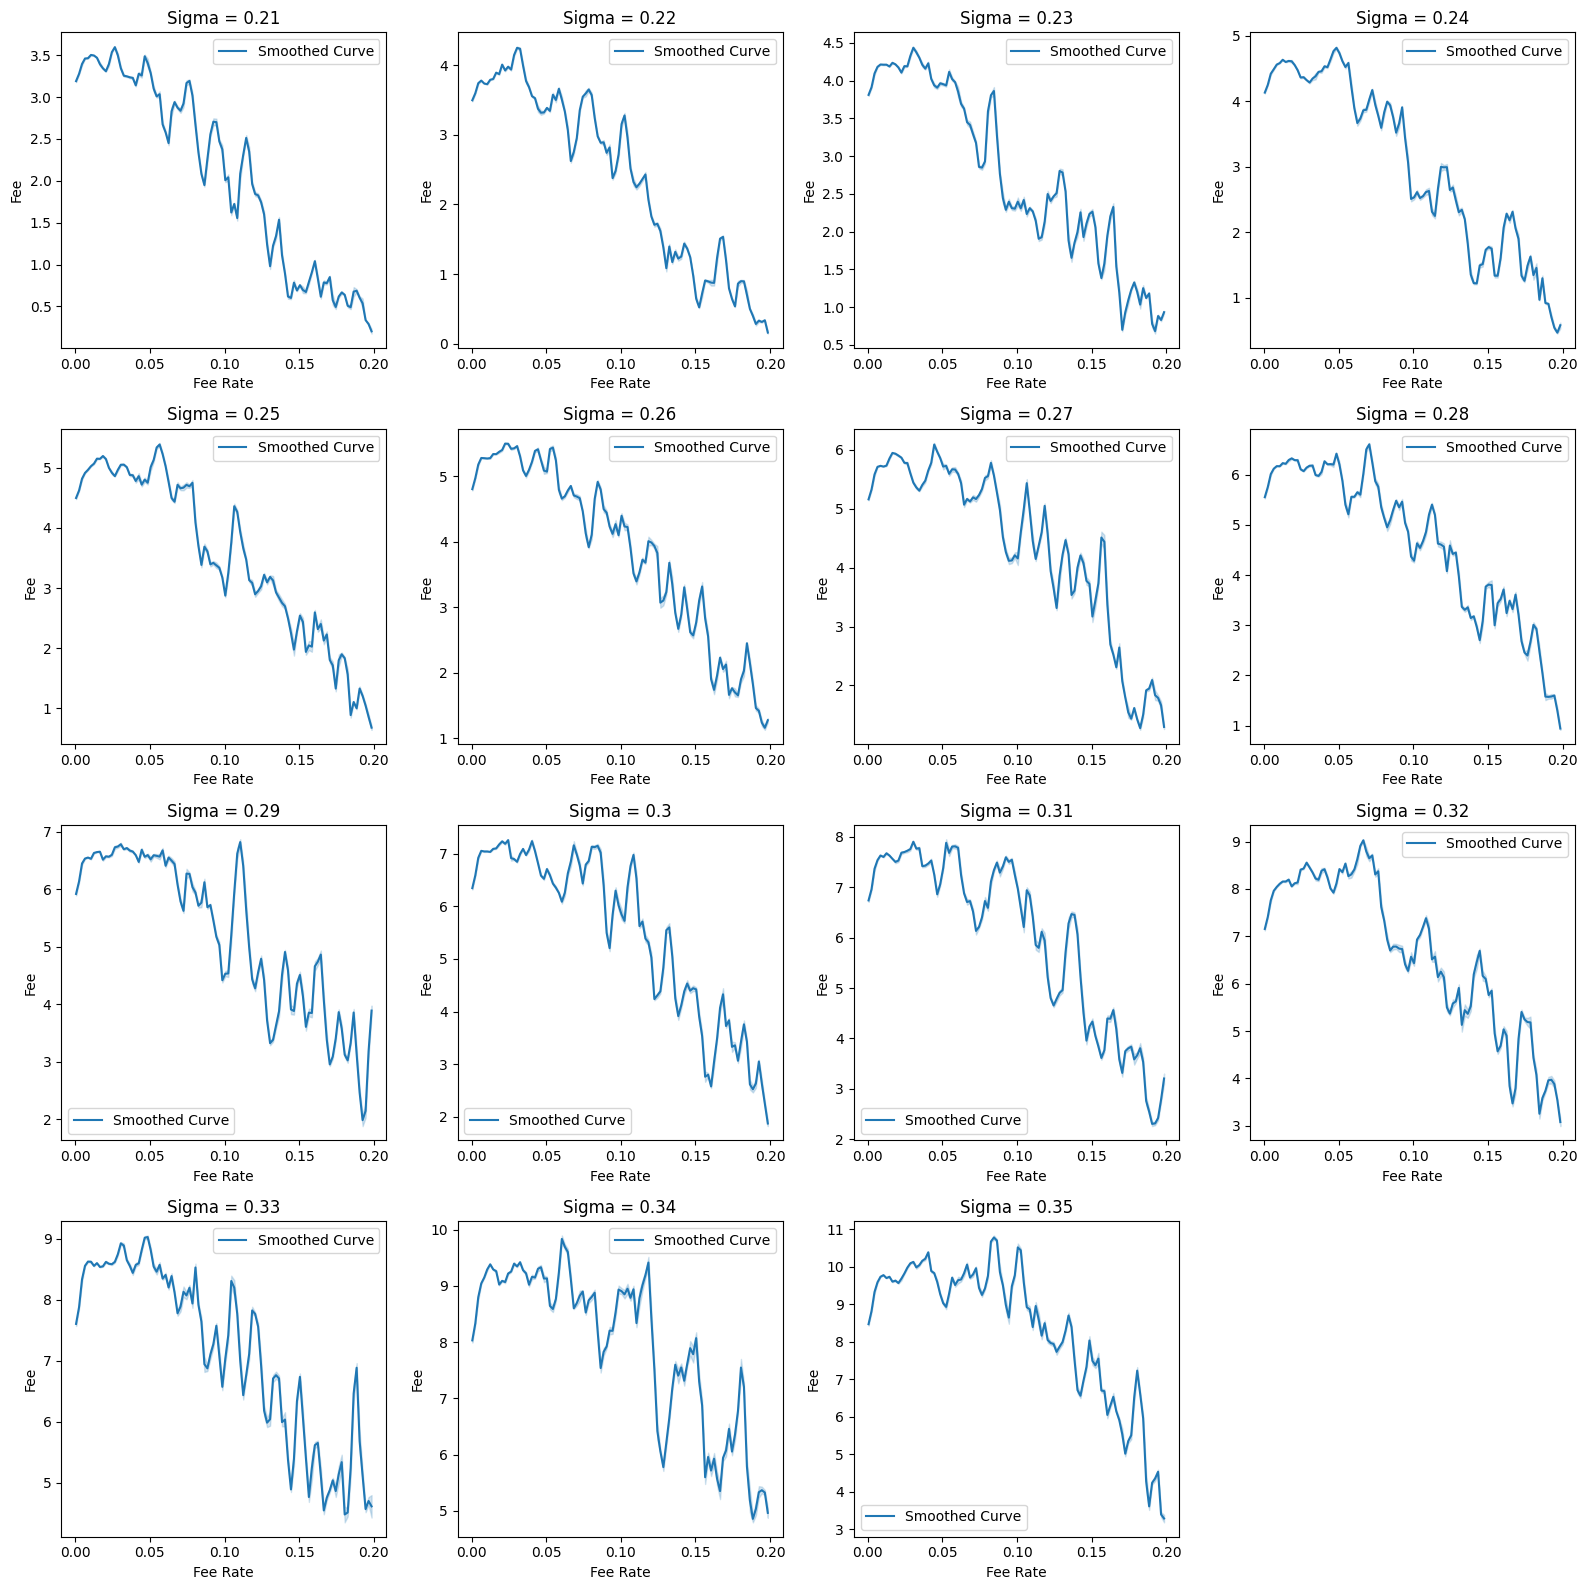

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/combined2.csv')
# sort df by sigma and fee_rate
df = df.sort_values(['sigma', 'fee_rate'])

# Assuming your DataFrame is named df
def plot_smoothed_fee_rate(df, window_size=5):
    sigmas = df['sigma'].unique()
    total_sigmas = len(sigmas)
    
    # Determine the number of figures needed (each figure will have 16 subplots)
    num_figures = (total_sigmas // 16) + (1 if total_sigmas % 16 != 0 else 0)
    
    for fig_num in range(num_figures):
        # Create a 4x4 grid of subplots
        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        axes = axes.flatten()  # Flatten axes to make it iterable

        # Get the sigma values for this figure (up to 16 per figure)
        start_idx = fig_num * 16
        end_idx = min(start_idx + 16, total_sigmas)
        current_sigmas = sigmas[start_idx:end_idx]

        for i, sigma in enumerate(current_sigmas):
            sigma_df = df[df['sigma'] == sigma]  # Filter data for current sigma
            
            # Sort by fee_rate to ensure correct plotting
            sigma_df = sigma_df.sort_values(by='fee_rate')
            
            fee_rates = sigma_df['fee_rate'].values
            fees = sigma_df['fee'].values
            
            # Apply moving average smoothing (rolling mean)
            smoothed_fees = pd.Series(fees).rolling(window=window_size, min_periods=1, center=True).mean()
            
            # Plot the smoothed fee vs fee_rate on the corresponding subplot
            sns.lineplot(x=fee_rates, y=smoothed_fees, ax=axes[i], label='Smoothed Curve')
            
            # Set title and labels for the subplot
            axes[i].set_title(f'Sigma = {sigma}')
            axes[i].set_xlabel('Fee Rate')
            axes[i].set_ylabel('Fee')

        # Remove any unused subplots (if less than 16 sigma in the last figure)
        for j in range(len(current_sigmas), 16):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.savefig(f'narrow_smoothed_fee_rate_figure_{fig_num}.png')
        plt.show()

# Call the function to visualize smoothed line plots
plot_smoothed_fee_rate(df, window_size=100)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/static_simulation_results_-1.csv')
df = df[['fee_rate', 'fee', 'pnl']]
dynamic = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/dynamic_simulation_results_20241016_113453.csv')
dynamic2 = pd.read_csv('/home/shiftpub/Dynamic_AMM/results/dummy_results/dynamic_simulation_results_20241016_115415.csv')
dynamic['fee_rate'] = 'vol-based'
dynamic2['fee_rate'] = 'distance_based'
dynamic = dynamic[['fee_rate', 'fee', 'pnl']]
dynamic2 = dynamic2[['fee_rate', 'fee', 'pnl']]
print(df.columns)
print(dynamic.columns)
combined_df = pd.concat([df, dynamic, dynamic2], ignore_index=True)
print(combined_df.head())

Index(['fee_rate', 'fee', 'pnl'], dtype='object')
Index(['fee_rate', 'fee', 'pnl'], dtype='object')
  fee_rate       fee        pnl
0   0.0005  0.160160  13.807829
1   0.0005  0.154314  14.069886
2   0.0005  0.155113  13.833986
3   0.0005  0.149930  12.778634
4   0.0005  0.145880  13.034070


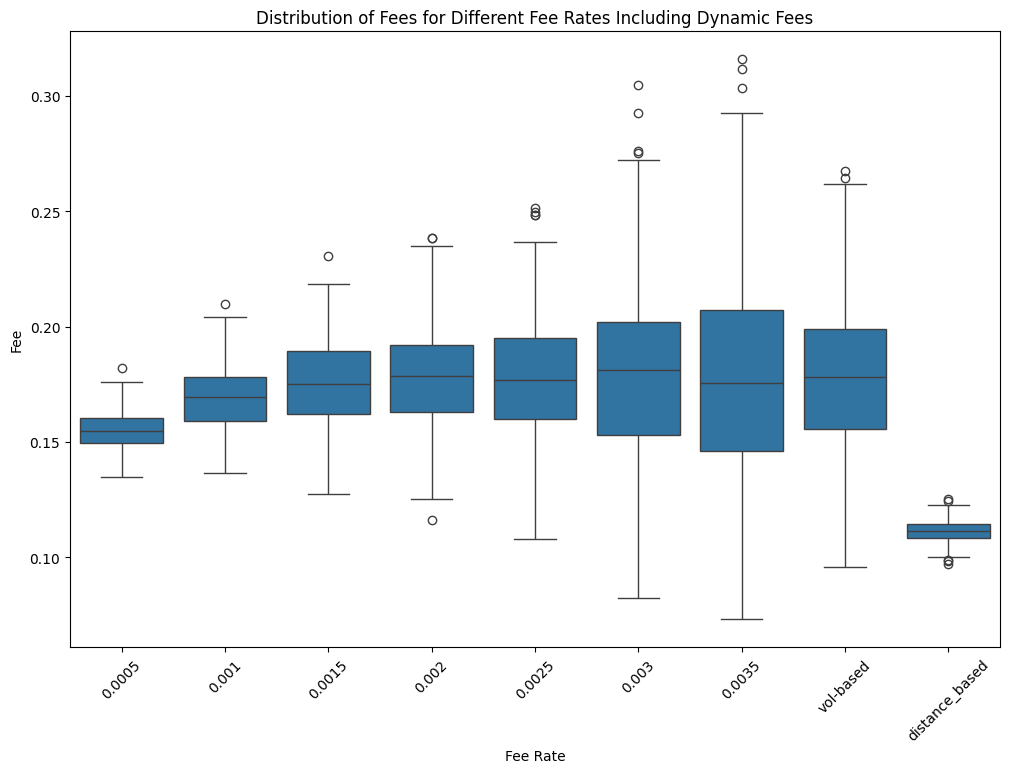

In [20]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Draw the boxplot with dynamic fees included
sns.boxplot(x='fee_rate', y='fee', data=combined_df)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates Including Dynamic Fees')

# Show the plot
plt.show()

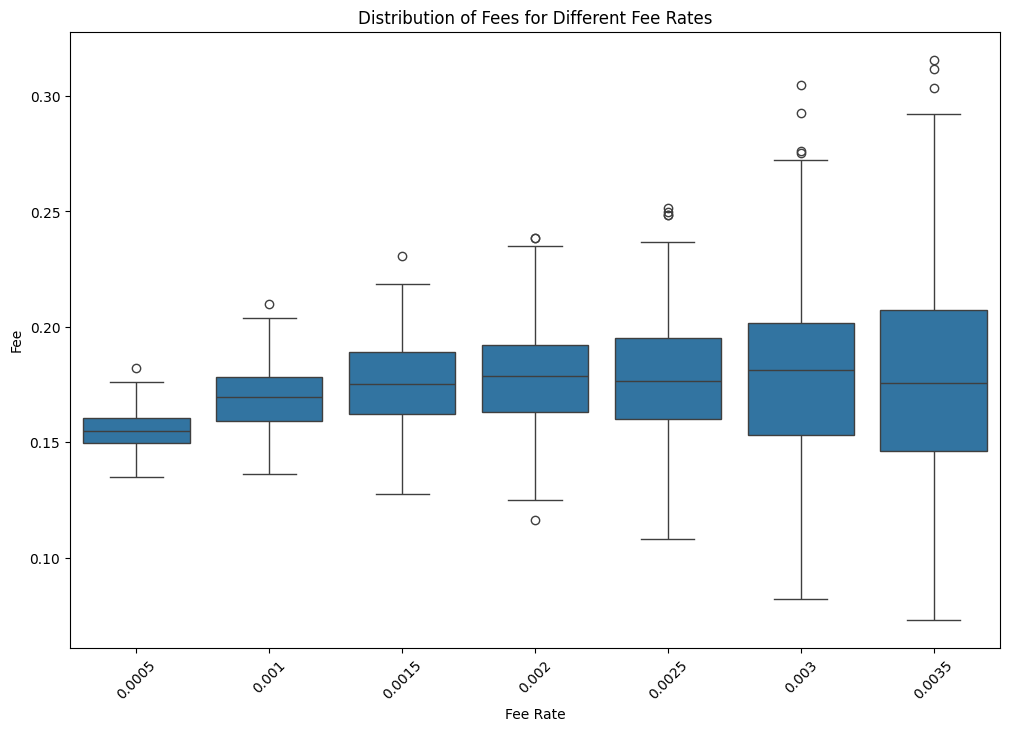

In [4]:
# plot boxplot of fee for different fee rates
plt.figure(figsize=(12, 8))
sns.boxplot(x='fee_rate', y='fee', data=df)
plt.xticks(rotation=45)
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates')
plt.show()